# Waterfilling Levels

In [1]:
import sys
sys.path.insert(1, '../../functions')
import importlib
import numpy as np
import nbformat
import plotly.express
import plotly.express as px
import pandas as pd
import scipy.optimize as optimization
import food_bank_functions
import food_bank_bayesian
import matplotlib.pyplot as plt
import seaborn as sns
from food_bank_functions import *
from food_bank_bayesian import *
importlib.reload(food_bank_functions)

<module 'food_bank_functions' from '../../functions\\food_bank_functions.py'>

### Plotting the distribution

In [2]:
vals = np.loadtxt('../../data/gaussian/vals_15_var_3.csv', delimiter=",")
support = np.loadtxt('../../data/gaussian/support_15_var_3.csv', delimiter=",")

In [13]:
print(vals)
print(support)
vals[0] = vals[0] + (1 - np.sum(vals))

[0.0000e+00 3.3000e-04 5.3400e-03 4.5740e-02 1.8204e-01 3.3487e-01
 2.8992e-01 1.1717e-01 2.2520e-02 2.0000e-03 7.0000e-05]
[ 2.          4.7         7.4        10.1        12.8        15.5
 18.2        20.9        23.6        26.3        27.20911003]


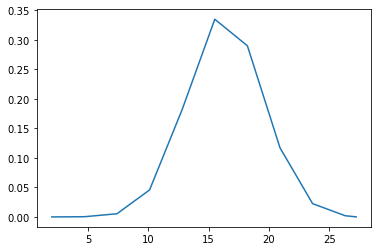

In [5]:
plt.plot(support, vals)

### Test

In [19]:
n = 6
sorted_distribution = support
weights = vals
expected_demand = np.dot(vals, support)
print(expected_demand)
max_budget = n * expected_demand

16.33501163770181


In [6]:
print(max_budget)

98.01006982621087


In [7]:
np.sum(vals)

1.0

In [8]:
group_demands = np.random.choice(size=n, a=sorted_distribution, p=vals)
print(group_demands)

[12.8 18.2 10.1 15.5 15.5 18.2]


In [9]:
print(waterfilling_waste(group_demands, max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


In [10]:
print(greedy(group_demands, max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


In [11]:
print(constant_threshold(group_demands,max_budget,expected_demand))

[12.8        16.33501164 10.1        15.5        15.5        16.33501164]


In [12]:
print(waterfilling_proportional_remaining(group_demands, max_budget))

[12.8        17.04201397 10.1        15.5        15.5        18.2       ]


In [13]:
print(waterfilling_dynamic_waste([expected_demand for x in range(n)],group_demands,max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


In [14]:
print(waterfilling_dynamic_full_waste([expected_demand for x in range(n)],group_demands,max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


In [15]:
print(waterfilling_weights_waste_iid(weights, sorted_distribution, group_demands, max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


In [16]:
print(weights)
print(sorted_distribution)

[1.11022302e-16 3.30000000e-04 5.34000000e-03 4.57400000e-02
 1.82040000e-01 3.34870000e-01 2.89920000e-01 1.17170000e-01
 2.25200000e-02 2.00000000e-03 7.00000000e-05]
[ 2.          4.7         7.4        10.1        12.8        15.5
 18.2        20.9        23.6        26.3        27.20911003]


In [17]:
print(waterfilling_weights_full_waste_iid(weights, sorted_distribution, group_demands, max_budget))

[12.8 18.2 10.1 15.5 15.5 18.2]


# Experiments

## Varying Number of Groups

### Look at scaling with n

In [20]:
max_n = 100
num_iterations = 50
print(weights)
print(sorted_distribution)

[0.0000e+00 3.3000e-04 5.3400e-03 4.5740e-02 1.8204e-01 3.3487e-01
 2.8992e-01 1.1717e-01 2.2520e-02 2.0000e-03 7.0000e-05]
[ 2.          4.7         7.4        10.1        12.8        15.5
 18.2        20.9        23.6        26.3        27.20911003]


In [21]:
data_dict = {'NumGroups':[], 'Norm':[], 'Dynamic':[],'Weights':[], 'Adapt_Threshold':[], 'Threshold':[],'Greedy':[], 'Dynamic_Full':[], 'Weights_Full':[]}

for n in np.arange(2,max_n+1,1):
    n = max(int(n),1)
    group_expected_demands = np.zeros(n) + 15    
    budget = n*15
    print(n)
    for i in range(num_iterations):
        data_dict['NumGroups'].append(n)

        
        group_demands = np.random.choice(size=n, a=support, p=vals)
        opt = waterfilling_waste(group_demands,budget)
        
        weights_sol = waterfilling_weights_waste_iid(weights, sorted_distribution, group_demands, budget)
        weights_full_sol = waterfilling_weights_full_waste_iid(weights, sorted_distribution, group_demands, budget)
        dynamic = waterfilling_dynamic_waste(group_expected_demands,group_demands,budget)
        dynamic_full = waterfilling_dynamic_full_waste(group_expected_demands, group_demands, budget)
        proportional_threshold = waterfilling_proportional_remaining(group_demands, budget)
        greed_sol = greedy(group_demands,budget)
        threshold = constant_threshold(group_demands,budget,expected_demand)
        
        
        
        data_dict['Norm'].append('L1')
        data_dict['Weights'].append(np.sum(np.absolute(opt - weights_sol)))
        data_dict['Dynamic'].append(np.sum(np.absolute(opt-dynamic)))
        data_dict['Adapt_Threshold'].append(np.sum(np.absolute(opt - proportional_threshold)))
        data_dict['Greedy'].append(np.sum(np.absolute(opt-greed_sol)))
        data_dict['Threshold'].append(np.sum(np.absolute(opt-threshold)))
        data_dict['Dynamic_Full'].append(np.sum(np.absolute(opt-dynamic_full)))
        data_dict['Weights_Full'].append(np.sum(np.absolute(opt-weights_full_sol)))
        
        data_dict['NumGroups'].append(n)
        data_dict['Norm'].append('Linf')
        data_dict['Weights'].append(np.max(np.absolute(opt - weights_sol)))
        data_dict['Dynamic'].append(np.max(np.absolute(opt-dynamic)))
        data_dict['Adapt_Threshold'].append(np.max(np.absolute(opt - proportional_threshold)))
        data_dict['Greedy'].append(np.max(np.absolute(opt-greed_sol)))
        data_dict['Threshold'].append(np.max(np.absolute(opt-threshold)))
        data_dict['Dynamic_Full'].append(np.max(np.absolute(opt-dynamic_full)))
        data_dict['Weights_Full'].append(np.max(np.absolute(opt-weights_full_sol)))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [22]:
df = pd.DataFrame(data_dict).melt(id_vars=["NumGroups", 'Norm'])

In [23]:
df.columns

Index(['NumGroups', 'Norm', 'variable', 'value'], dtype='object')

In [24]:
df.head

<bound method NDFrame.head of        NumGroups  Norm      variable      value
0              2    L1       Dynamic   0.500000
1              2  Linf       Dynamic   0.500000
2              2    L1       Dynamic   0.000000
3              2  Linf       Dynamic   0.000000
4              2    L1       Dynamic   0.000000
...          ...   ...           ...        ...
69295        100  Linf  Weights_Full   4.495055
69296        100    L1  Weights_Full  16.187911
69297        100  Linf  Weights_Full   8.023083
69298        100    L1  Weights_Full  11.114040
69299        100  Linf  Weights_Full   5.342428

[69300 rows x 4 columns]>

In [25]:
df[df.variable == 'Weights'].head

<bound method NDFrame.head of        NumGroups  Norm variable      value
9900           2    L1  Weights   1.535737
9901           2  Linf  Weights   1.535737
9902           2    L1  Weights   0.000000
9903           2  Linf  Weights   0.000000
9904           2    L1  Weights   2.071475
...          ...   ...      ...        ...
19795        100  Linf  Weights   5.263265
19796        100    L1  Weights  11.983398
19797        100  Linf  Weights   0.833460
19798        100    L1  Weights  11.795791
19799        100  Linf  Weights   1.228399

[9900 rows x 4 columns]>

<AxesSubplot:title={'center':'Gaussian L1'}, xlabel='NumGroups', ylabel='value'>

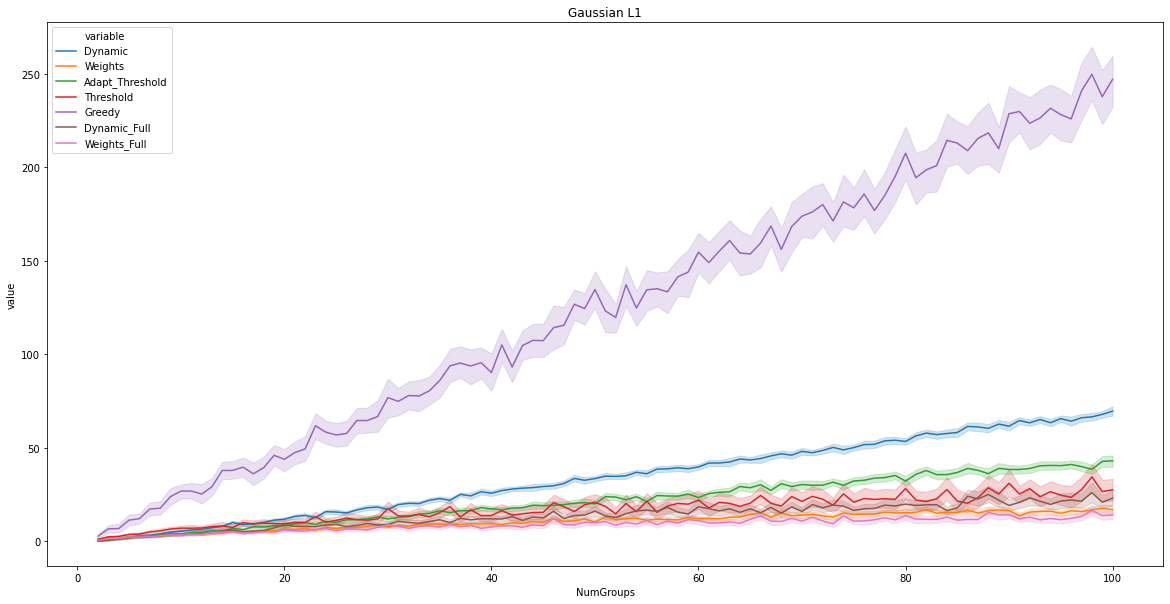

In [26]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
plt.figure(figsize=(20,10))
plt.title('Gaussian L1')
sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

<AxesSubplot:title={'center':'Gaussian Linf'}, xlabel='NumGroups', ylabel='value'>

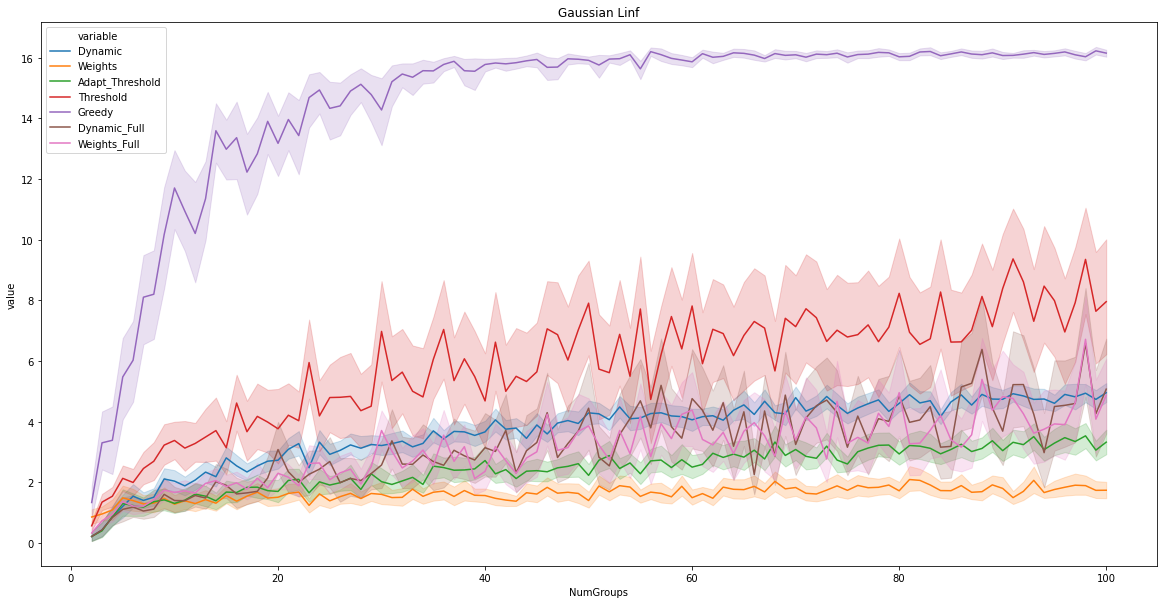

In [27]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
plt.figure(figsize=(20,10))
plt.title('Gaussian Linf')
sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'Linf'])

In [48]:
data_dict = {'Group':[], 'Weights_Full':[], 'Weights_Online':[],'Dynamic_Full':[], 'Dynamic_Online':[], 'True':[]}
num_iterations = 1
for i in range(num_iterations):
    

    max_n = 100
    
    weights = np.loadtxt('../../data/gaussian/vals_15_var_3.csv', delimiter=",")
    sorted_support = np.loadtxt('../../data/gaussian/support_15_var_3.csv', delimiter=",")
    expected_demands = [15 for x in range(max_n)]
    # print(weights)
    # print(sorted_support)
    # print(expected_demands)
    max_budget = max_n*15
    
    
    
    group_demands = np.random.choice(size=max_n, a=sorted_support, p=weights)
    # print('Demands for experiment:' + str(group_demands))
    
    dynamic_full = np.copy(expected_demands)
    dynamic_online = np.sort(np.copy(expected_demands))
    
    dynamic_online_budget = max_budget
    weights_online_budget = max_budget
    
    weights_online_support = np.copy(sorted_support)
    weights_online_vals = np.copy(weights)*max_n
    
    weights_full_support = np.copy(sorted_support)
    weights_full_vals = np.copy(weights)*max_n
    
    for n in range(max_n):
        # Solve for the various waterfilling levels
        data_dict['Group'].append(n)
        
        # Adds on the true waterfilling level
        data_dict['True'].append(max(waterfilling_sorted(np.sort(np.copy(group_demands)), max_budget)))
        
        
        # Dynamic_Full
        
        # Replaces current town's demand with realized demand
        dynamic_full[n] = group_demands[n]
        # Sorts demands
        dynamic_full_sorted = np.sort(dynamic_full)
        # Appends maximum allocation based on full demand with full budget
        data_dict['Dynamic_Full'].append(max(waterfilling_sorted(dynamic_full_sorted, max_budget)))
        
        # Dynamic_Online
        
        # Removes expected demand for current agent from list
        dynamic_online = delete_sorted(dynamic_online, expected_demands[n])
        
        # adds in the demand for current location
        new_sorted_list, index = insert_sorted(dynamic_online, group_demands[n])
        tmp_sol = waterfilling_sorted(new_sorted_list, dynamic_online_budget)
        data_dict['Dynamic_Online'].append(max(tmp_sol))
        # subtracts off the allocation for the next round
        dynamic_online_budget -= min(tmp_sol[index], dynamic_online_budget, group_demands[n])
        
        
        # Weights_Full
        
        # Updating the weights for the observed group
        obs_demand = group_demands[n]
        
        index = np.argmin(np.abs(weights_full_support - obs_demand))
        weights_full_vals -= weights
        weights_full_vals[index] += 1
        
        data_dict['Weights_Full'].append(max(waterfilling_sorted_weights(weights_full_support, weights_full_vals, max_budget)))
        
        
        # Weights_Online
        obs_demand = group_demands[n]
        
        index = np.argmin(np.abs(weights_online_support - obs_demand))
        weights_online_vals -= weights
        weights_online_vals[index] += 1        
        
        
        tmp_sol = waterfilling_sorted_weights(weights_online_support, weights_online_vals, weights_online_budget)
        weights_online_budget -= min(obs_demand, weights_online_budget, tmp_sol[index])
        
        weights_online_vals[index] -= 1
        
        data_dict['Weights_Online'].append(max(tmp_sol))

In [49]:
np.std(data_dict['True'])

0.0

In [50]:
df = pd.DataFrame(data_dict).melt(id_vars="Group")

In [51]:
df = df[df.variable != 'Dynamic_Online']
df = df[df.variable != 'Dynamic_Full']

Text(0.5, 0, 'Estimated Level')

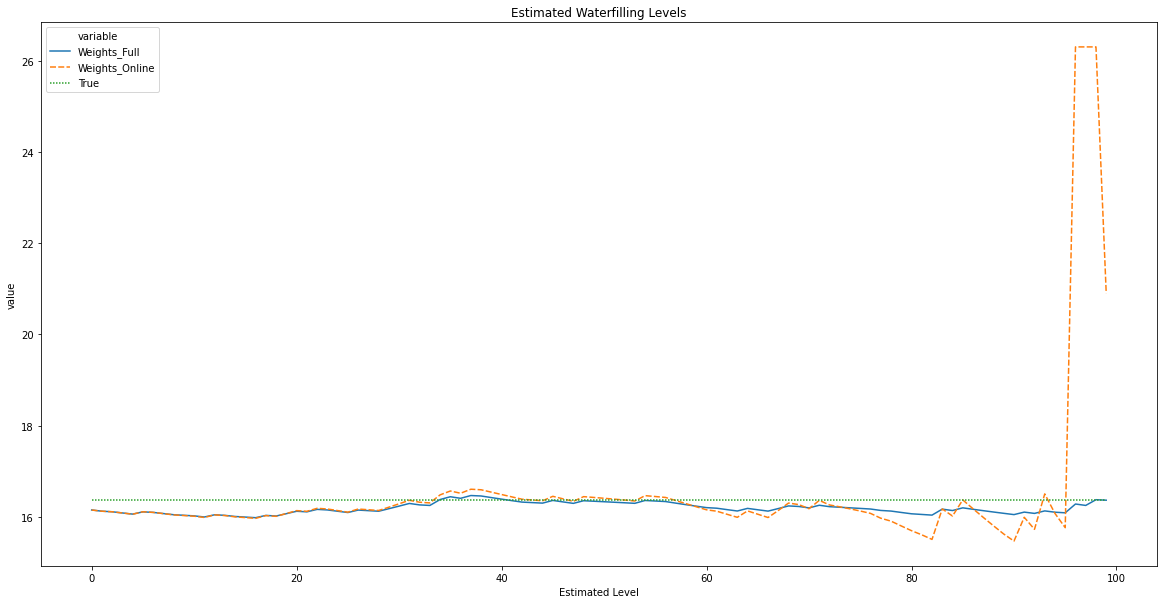

In [52]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Group', y='value', style='variable', hue = 'variable', data=df)
plt.title('Estimated Waterfilling Levels')
plt.xlabel('Estimated Level')